In [46]:
from uk_covid19 import Cov19API
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as wdg
import numpy as np
from matplotlib import cm
from ipywidgets import Button

In [47]:

filters = [
     'areaType=overview' 
]


# values here are the names of the PHE metrics
structure = {
    "date": "date",
    "firstdose": "newPeopleVaccinatedFirstDoseByPublishDate",
    "seconddose": "newPeopleVaccinatedSecondDoseByPublishDate",
    "thirddose" : "newPeopleVaccinatedThirdInjectionByPublishDate"
}
api = Cov19API(filters=filters, structure=structure)
dose=api.get_json()


In [48]:
with open("dose.json", "wt") as OUTF:
    json.dump(dose, OUTF)

In [49]:
with open("dose.json", "rt") as INFILE:
    data=json.load(INFILE)

In [50]:
datalist=data['data']
dates=[dictionary['date'] for dictionary in datalist ]
dates.sort()



In [51]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [52]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
index=pd.date_range(startdate, enddate, freq='D')
doseseriesdf=pd.DataFrame(index=index, columns=['firstdose', 'seconddose', 'thirddose'])



In [53]:

for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
    date=parse_date(entry['date'])
    for column in ['firstdose', 'seconddose', 'thirddose']:

        if pd.isna(doseseriesdf.loc[date, column]): 
            value= float(entry[column]) if entry[column]!=None else 0.0
            doseseriesdf.loc[date, column]=value
            

doseseriesdf.fillna(0.0, inplace=True)


<AxesSubplot:>

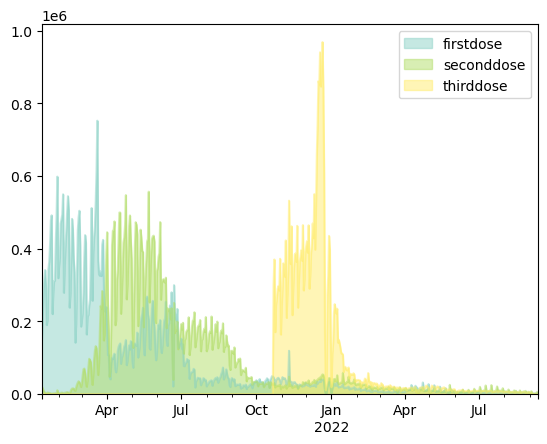

In [54]:
doseseriesdf.plot.area(stacked=False,colormap="Set3")


In [55]:
doseseriesdf.to_pickle("doseseriesdf.pkl")

In [56]:
doseseries_df=pd.read_pickle("doseseriesdf.pkl")

In [70]:
doseseries=wdg.SelectMultiple(
    options=['firstdose', 'seconddose', 'thirddose'],
    value=['firstdose', 'seconddose', 'thirddose'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)


controls=wdg.HBox([doseseries, scale])

def doseseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        doseseries_df[list(gcols)].plot(logy=logscale,colormap='tab20b')
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")


graph=wdg.interactive_output(doseseries_graph, {'gcols': doseseries, 'gscale': scale})

display(controls, graph)

Output()

In [58]:
# stack series and scale on top of each other
ctrls=wdg.VBox([doseseries, scale])
# put the graph and the controls side by side
form=wdg.HBox([graph, ctrls])

# Now form contains the entire interface
display(form)

In [60]:
jsondata={}
def access_api():
    """ Accesses the PHE API. Returns raw data in the same format as data loaded from the "canned" JSON file. """
    return {} # return data read from the API

In [61]:

def wrangle_data(rawdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Edit to include the code that wrangles the data, creates the dataframe and fills it in. """

    for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
        date=parse_date(entry['date'])
        for column in ['firstdose', 'seconddose', 'thirddose']:
            if pd.isna(doseseriesdf.loc[date, column]): 
                value= float(entry[column]) if entry[column]!=None else 0.0

                doseseriesdf.loc[date, column]=value
                doseseriesdf.fillna(0.0, inplace=True)
    df=doseseriesdf
    return df

df=wrangle_data(jsondata) # df is the dataframe for plotting

In [62]:


def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    apidata=access_api()
    global df
    df=wrangle_data(apidata)
    refresh_graph()
    apibutton.icon="check"

def access_api2(button):

    apibutton.icon="check"
    apibutton.style.button_color='#32CD32'
    apibutton.description='Successful'
    apibutton.disabled=True
    
apibutton=wdg.Button(
    description='REFRESH',
    disabled=False,
    button_style='info', 
    tooltip="Keep calm and carry on",

    icon='retweet'
)
apibutton.style.button_color='#4682B4'

apibutton.on_click(api_button_callback) # the name of your function inside these brackets
apibutton.on_click(access_api2)
display(apibutton)

# run all cells before clicking on this button

Button(button_style='info', description='REFRESH', icon='retweet', style=ButtonStyle(button_color='#4682B4'), …

In [63]:
def plot_random_walk(walk):
    df[walk].plot(colormap='RdYlBu')
    plt.show() # important! update won't work properly without this
    
whichwalk=wdg.Dropdown(
    options=['firstdose', 'seconddose','thirddose'],
    value='firstdose',
    description='Dose: ',
    disabled=False,
)

def refresh_graph():
    """ We change the value of the widget in order to force a redraw of the graph;
    this is useful when the data have been updated. This is a bit of a gimmick; it
    needs to be customised for one of your widgets. """
    current=whichwalk.value
    if current==whichwalk.options[0]:
        other=whichwalk.options[1]
    else:
        other=whichwalk.options[0]
    whichwalk.value=other # forces the redraw
    whichwalk.value=current # now we can change it back
    
    
graph=wdg.interactive_output(plot_random_walk, {'walk': whichwalk})
    
display(whichwalk, graph)

Dropdown(description='Dose: ', options=('firstdose', 'seconddose', 'thirddose'), value='firstdose')

Output()